In [1]:
%env THEANO_FLAGS='device=gpu0','floatX=float32'

import os
import os.path as osp

import numpy as np

import theano
import theano.tensor as T
from lasagne import *

%matplotlib nbagg

import matplotlib.pyplot as plt

env: THEANO_FLAGS='device=gpu0','floatX=float32'


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


In [2]:
import sklearn

print sklearn.__version__

0.18


In [3]:
%%sh

wget -q -nc https://raw.githubusercontent.com/amitgroup/amitgroup/master/amitgroup/io/mnist.py

In [4]:
### http://g.sweyla.com/blog/2012/mnist-numpy/
import mnist

In [5]:
%%sh

mkdir -p mnist && {
    cd mnist;
    wget -q -nc http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz &&
    wget -q -nc http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz &&
    wget -q -nc http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz &&
    wget -q -nc http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz &&
    gunzip *.gz
}

gzip: t10k-images-idx3-ubyte already exists;	not overwritten
gzip: t10k-labels-idx1-ubyte already exists;	not overwritten
gzip: train-images-idx3-ubyte already exists;	not overwritten
gzip: train-labels-idx1-ubyte already exists;	not overwritten


In [6]:
X, y = mnist.load_mnist(dataset='training', path='mnist/')
X = X.reshape(-1, 1, 28, 28).astype('float32')

X_test, y_test = mnist.load_mnist(dataset='testing', path='mnist/')
X_test = X_test.reshape(-1, 1, 28, 28).astype('float32')

In [7]:
from ae import CAE

In [8]:
cae = CAE(n_codes=16)
cae.load('CAE_16.npz')

In [9]:
X = cae.decode(cae.encode(X))
X_test = cae.decode(cae.encode(X_test))

In [10]:
class Net(object):
    def save(self, path):
        return np.savez(path, *layers.get_all_param_values(self.net))
    
    def load(self, path):
        with np.load(path) as f:
            param_values = [f['arr_%d' % i] for i in range(len(f.files))]
            layers.set_all_param_values(self.net, param_values)

        return self
    
    def __str__(self):
        def get_n_params(l):
            return np.sum([
                np.prod(l.get_params()[0].get_value().shape)
                for param in l.get_params()
            ])

        return '\n'.join([
            '%s\n  output shape:%s\n  number of params: %s' % (l, l.output_shape, get_n_params(l))
            for l in layers.get_all_layers(self.net)
        ])

In [11]:
class Clf(Net):
    def __init__(self, X_batch):
        super(Clf, self).__init__()
        
        input_l = layers.InputLayer(shape=(None, 1, 28, 28), input_var=X_batch)

        conv1 = layers.Conv2DLayer(
            input_l,
            num_filters=8,
            filter_size=(3, 3),
            nonlinearity=nonlinearities.elu
        )
        
        conv2 = layers.Conv2DLayer(
            conv1,
            num_filters=16,
            filter_size=(3, 3),
            nonlinearity=nonlinearities.elu
        )

        pool1 = layers.GlobalPoolLayer(
            conv2,
            pool_function=T.mean
        )

        dense = layers.DenseLayer(
            pool1,
            num_units = 1,
            nonlinearity=nonlinearities.sigmoid
        )
        
        self.net = dense
        
        self.predictions = T.flatten(layers.get_output(dense))

In [12]:
class Reweighter(Net):
    def __init__(self, X_batch):
        super(Reweighter, self).__init__()
        
        input_l = layers.InputLayer(shape=(None, 1, 28, 28), input_var=X_batch)

        conv1 = layers.Conv2DLayer(
            input_l,
            num_filters=8,
            filter_size=(3, 3),
            nonlinearity=nonlinearities.elu
        )
        
        conv2 = layers.Conv2DLayer(
            conv1,
            num_filters=16,
            filter_size=(3, 3),
            nonlinearity=nonlinearities.elu
        )

        pool1 = layers.MaxPool2DLayer(
            conv2,
            pool_size=(2, 2)
        )
        
        conv3 = layers.Conv2DLayer(
            pool1,
            num_filters=32,
            filter_size=(3, 3),
            nonlinearity=nonlinearities.elu
        )
        
        pool2 = layers.MaxPool2DLayer(
            conv3,
            pool_size=(2, 2)
        )

        dense = layers.DenseLayer(
            pool2,
            num_units = 1,
            nonlinearity=nonlinearities.sigmoid
        )
        
        self.net = dense
        
        self.weights = T.flatten(layers.get_output(dense))

In [13]:
X_batch = T.ftensor4(name='X_batch')

clf = Clf(X_batch)
reweighter = Reweighter(X_batch)

print clf
print
print reweighter

  output shape:(None, 1, 28, 28)
  number of params: 0.0
  output shape:(None, 8, 26, 26)
  number of params: 144
  output shape:(None, 16, 24, 24)
  number of params: 2304
  output shape:(None, 16)
  number of params: 0.0
  output shape:(None, 1)
  number of params: 32

  output shape:(None, 1, 28, 28)
  number of params: 0.0
  output shape:(None, 8, 26, 26)
  number of params: 144
  output shape:(None, 16, 24, 24)
  number of params: 2304
  output shape:(None, 16, 12, 12)
  number of params: 0.0
  output shape:(None, 32, 10, 10)
  number of params: 9216
  output shape:(None, 32, 5, 5)
  number of params: 0.0
  output shape:(None, 1)
  number of params: 1600


In [14]:
y_batch = T.fvector(name='y')
w_batch = reweighter.weights

p_batch = clf.predictions

loss_gen = -T.sum(w_batch * (1 - y_batch) * T.log(1 - p_batch)) / (T.sum((1 - y_batch) * w_batch) + 1.0e-6)
loss_real = -T.mean(y_batch * T.log(p_batch))

pure_loss = 0.5 * (loss_gen + loss_real)

reg_clf = regularization.regularize_network_params(clf.net, regularization.l2)
reg_rw = regularization.regularize_network_params(reweighter.net, regularization.l2)

loss = pure_loss + 1.0e-5 * (reg_clf + reg_rw)

neg_loss = -pure_loss + 1.0e-5 * (reg_clf + reg_rw)

In [15]:
w_batch.eval({X_batch : X[:10]}).shape

(10,)

In [16]:
p_batch.eval({X_batch : X[:10]}).shape

(10,)

In [17]:
loss.eval({
    X_batch : X[:10],
    y_batch : np.array([0 ] * 5 + [1] * 5, dtype='float32')
})

array(0.511023223400116, dtype=float32)

In [18]:
clf_params = layers.get_all_params(clf.net)
rw_params = layers.get_all_params(reweighter.net)

In [19]:
learning_rate = T.fscalar('learning rate')

clf_upd = updates.adadelta(loss, clf_params, learning_rate=learning_rate)
rw_upd = updates.adadelta(neg_loss, rw_params, learning_rate=learning_rate)

In [20]:
train_clf = theano.function([X_batch, y_batch, learning_rate], pure_loss, updates=clf_upd)
train_rw = theano.function([X_batch, y_batch, learning_rate], pure_loss, updates=rw_upd)

In [21]:
get_weights = theano.function([X_batch], w_batch)
get_predictions = theano.function([X_batch], p_batch)

In [22]:
class Watcher(object):
    def __init__(self, epoches):

        self.fig = plt.figure(figsize=(12, 6))
        self.ax = self.fig.add_subplot(111)
        
        self.ax.set_xlim([0.0, epoches - 1])
        self.ax.set_ylim([0.0, 1.0])

        self.mean_loss, = self.ax.plot([], [], label='mean loss', color='blue')
        self.loss, = self.ax.plot([], [], alpha=0.5, color='blue')
        
        self.ax.legend()
        
    def draw(self, ls):
        s = np.std(ls)
        self.ax.set_ylim(np.percentile(ls, q=2) - s, np.percentile(ls, q=98) + s)
        
        self.mean_loss.set_xdata(np.arange(ls.shape[0]))
        self.mean_loss.set_ydata(np.mean(ls, axis=1))
        
        self.loss.set_xdata(np.linspace(0, ls.shape[0] - 1, num=np.prod(ls.shape)))
        self.loss.set_ydata(ls.ravel())
        
        self.fig.canvas.draw()

In [24]:
codes = cae.encode(X)
codes_q95 = np.percentile(codes, q=95, axis=0)
codes_q05 = np.percentile(codes, q=5, axis=0)

codes_range = codes_q95 - codes_q05

In [25]:
def generate(size=1024, use_gm=True):
    codes = np.random.uniform(size=(size, 16)) * codes_range[None, :] + codes_q05[None, :]
    return cae.decode(codes.astype('float32'))

<IPython.core.display.Javascript object>


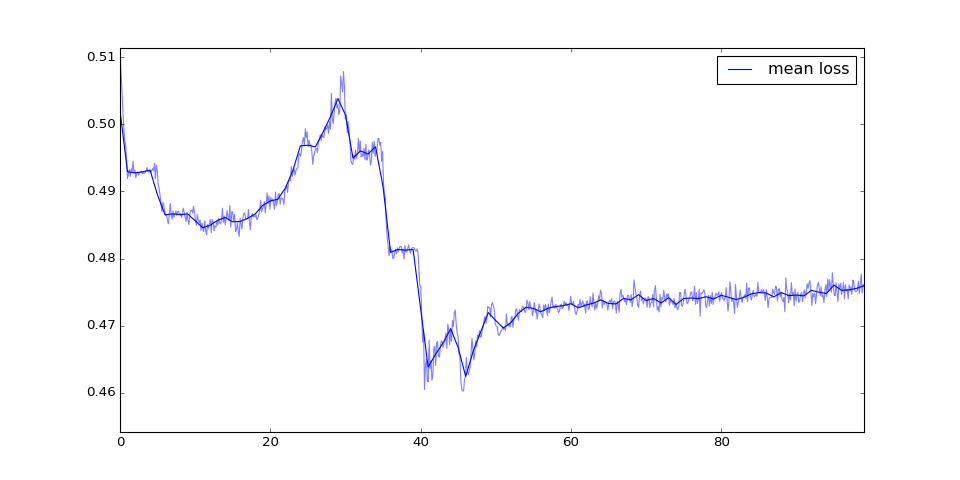

In [26]:
n_epoches = 100

n_batches = 8
watcher = Watcher(n_epoches)
batch_size = 2 ** 10

X_b = np.ndarray(shape=(2 * batch_size, 1, 28, 28), dtype='float32')
y_b = np.zeros(shape=(2 * batch_size, ), dtype='float32')
y_b[batch_size:] = 1.0

lr = np.float32(2.5e-1)

losses = np.zeros(shape=(n_epoches, n_batches))

for epoch in xrange(n_epoches):
    train = train_clf if (epoch % 5 == 0) else train_rw

    for batch in xrange(n_batches):
        X_b[:batch_size] = generate(size=batch_size)
        
        indx = np.random.choice(X.shape[0], size=batch_size)
        X_b[batch_size:] = X[indx]
        
        losses[epoch, batch] = train(X_b, y_b, lr)
    
    watcher.draw(losses[:(epoch + 1)])
    watcher.ax.set_title('')

In [27]:
get_weights(X[:10])

array([ 0.6673615 ,  0.68602043,  0.46321076,  0.53280854,  0.57671177,
        0.66449791,  0.57136935,  0.70154953,  0.52101326,  0.60584676], dtype=float32)

In [28]:
reweighter.save('reweighter.npz')
clf.save('clf.npz')

In [29]:
X_gen = generate(size=2**14)

w_gen = get_weights(X_gen)

<IPython.core.display.Javascript object>


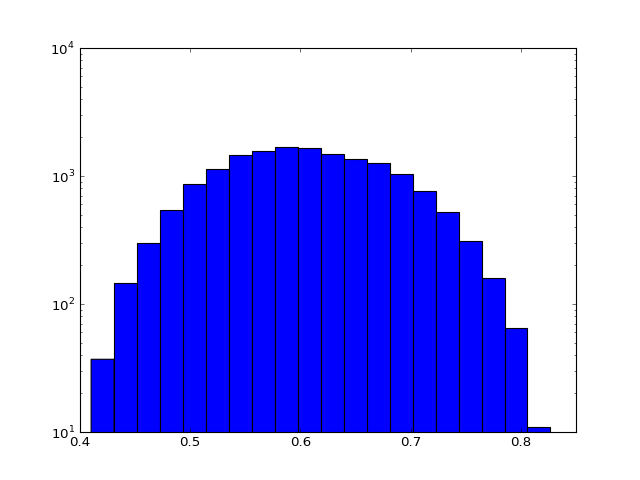

In [30]:
plt.figure()
plt.hist(w_gen, bins=20, log=True)
plt.show()

<IPython.core.display.Javascript object>


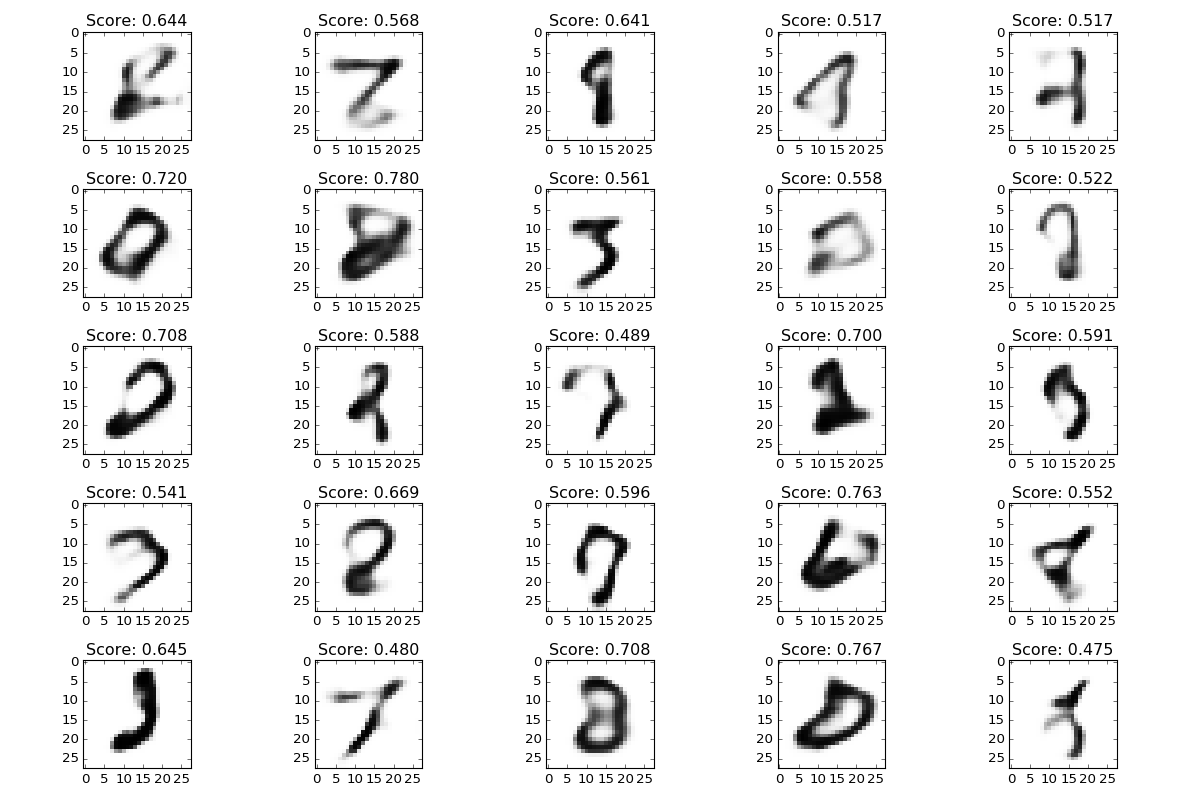

In [31]:
import itertools

nrows, ncols = 5, 5

indx = np.random.choice(X_gen.shape[0], size=25).reshape(5, 5)

fig, ax = plt.subplots(nrows, ncols, figsize=(ncols * 2 + 5, nrows * 2))

for i, j in itertools.product(range(nrows), range(ncols)):
    ax[i, j].imshow(
        X_gen[indx[i, j], 0],
        interpolation='None', cmap=plt.cm.gray_r, vmin=0.0, vmax=1.0
    )
    ax[i, j].set_title('Score: %.3f' % w_gen[indx[i, j]])

plt.tight_layout()
plt.show()